# Рекомендация тарифов

В данном проекте я строю модель, которая классифицирует пользователей по двум тарифам. 

Вначале я загружаю данные и делаю их беглый осмотр. 
Далее я разбиваю данные на обучающую, валидационную выборки и тестовую выборки.
На следующем шаге я исследую качество моделей, подбирая разные гиперпараметры. 
В конце я оцениваю модели на тестовой выборке. 
На финальной стадии я проверяю получившиеся модели на адекватность предсказанных результатов. 

## Откройте и изучите файл

In [67]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from scipy.stats import bernoulli

In [2]:
# Загружаем данные
data = pd.read_csv('/datasets/users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
# Смотрю на данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Посмотрю немного на переменные, например, есть ли люди, которые вообще не звонят.

In [4]:
# Срез
data.query('calls==0')['calls'].count()

40

Действительно, у 40 человек вообще нет звонков. Проверим, что у них же 0 минут разговора.

In [5]:
# срез
data.query('minutes==0')['minutes'].count()

40

Данные выглядят адекватными. 

Я создам одну дополнительную переменную - среднюю длина разговора.

In [6]:
# создаем переменную
data['minutes_per_call'] = data['minutes']/data['calls']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   calls             3214 non-null   float64
 1   minutes           3214 non-null   float64
 2   messages          3214 non-null   float64
 3   mb_used           3214 non-null   float64
 4   is_ultra          3214 non-null   int64  
 5   minutes_per_call  3174 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 150.8 KB


У 40 человек данная переменная будет не определена, потому что у них вообще нет звонков. Заменю пропуски для них на нули.

In [7]:
# Заполняю пропуски
data['minutes_per_call'] = data['minutes_per_call'].fillna(0)

Переведу мб в гб

In [8]:
data['gb_used'] = data['mb_used']/1000

Наша задача - это задача классификации, поэтому я буду рассматрировать три класса моделей: решающее дерево, случайный лес и логистическая регрессия. 

Для начала в целом я постараюсь понять общую картину, как разные классы распределены по разным фичам. У нас есть 4 фича: calls, minutes, massages и mb_used. Эти фичи скорее всего тоже как-то связаны между собой и эту связь хорошо бы хоть условно представлять. Когда пользователь выбирает тариф, он скорее всего пытается выбрать более выгодный тариф для своего пэттерна использования разных способов связи. В таком случае использование мессенджеров для звонков и переписки будет сабститутом для calls и messages будет отражаться в переменной mb_used. Я ожидаю, что mb_used должно отрицательно коррелировать с calls и messages.
Посморю на корреляции.

In [9]:
# Посмотрим на таблицу корреляций
data[['minutes_per_call', 'calls', 'minutes', 'messages', 'gb_used']].corr().style.background_gradient('coolwarm')

,minutes_per_call,calls,minutes,messages,gb_used
minutes_per_call,1.000000,0.148412,0.249895,-0.054004,-0.028443
calls,0.148412,1.000000,0.982083,0.177385,0.286442
minutes,0.249895,0.982083,1.000000,0.173110,0.280967
messages,-0.054004,0.177385,0.173110,1.000000,0.195721
gb_used,-0.028443,0.286442,0.280967,0.195721,1.000000


Во-первых, как можно увидеть, использование гб не скоррелировано отрицательно с разговорами и сообщениями. 
Во-вторых, мы видим, что суммарные минуты очень сильно скореллированы с числом звонков, а вот со средней длиной разговора не очень сильно. Поэтому я оставлю в фичах лишь calls и minutes_per_call.

Посмотрю, насколько данные сбалансированы в плане тарифов.

In [10]:
# считаю значения
data['is_ultra'].value_counts(True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Больше, чем 2/3 выборки - это пользователи тарифа Смарт, данные не сбалансированы по пользователям разных тарифов, это надо будет учесть в разбиении на выборки.

Я загрузила данные, добавила две переменные и увидела, что общая продолжительность разговоров и число звонков очень сильно скоррелированы друг с другом, а вот со средней длиной звонка не очень сильно. Я также увидела, что данные не сбалансированы, и большая часть клиентов пользуется тарифом Смарт.

## Разбейте данные на выборки

У меня нет отдельной тестовой выборки, поэтому все данные я разобью на тренировочную, валидационную и тестовую выборку.
Я разобью выборки в пропорции 3:1:1, то есть примерно 1928 наблюдений в обучающей выборке, и 643 в валидационной и тестовой.

In [15]:
# обозначаю features and target
features = data.drop(['is_ultra', 'mb_used', 'minutes'], axis=1)
target = data['is_ultra']

In [16]:
# отделяю тестовую выборку
features_train, features_test, target_train, target_test = (
    train_test_split(features, target, test_size=0.2, random_state=42, stratify = target)
)
features_train, features_valid, target_train, target_valid = (
    train_test_split(features_train, target_train, test_size=0.25, random_state=42, stratify=target_train)
)
display(features_train.shape[0])
display(features_valid.shape[0])
features_test.shape[0]

1928

643

643

Мы правильно разделили выборку на тренировочную, валидационную и тестовую. 

На данном этапе я разбила данные на обучающую, валидационную и тестовую выборки.

## Исследуйте модели

### Визуальное исследование данных

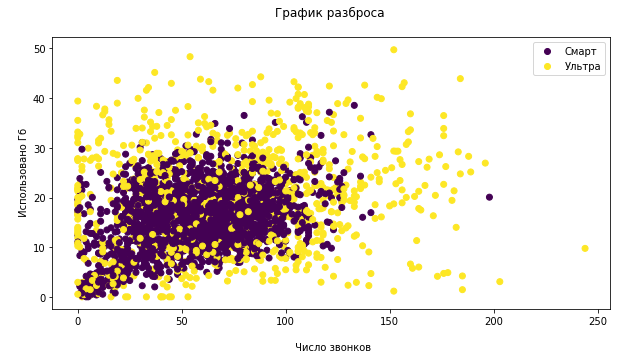

In [17]:
# Нарисуем скэттер плот 
plt.figure(figsize=(10,5))
plt.xlabel('\n Число звонков')
plt.ylabel('\n Использовано Гб')
plt.title('График разброса \n')
class_names = ['Смарт', 'Ультра']
scatter = plt.scatter(data['calls'], data['gb_used'], c = data['is_ultra']);
plt.legend(handles = scatter.legend_elements()[0], loc = 'upper right', labels = class_names);

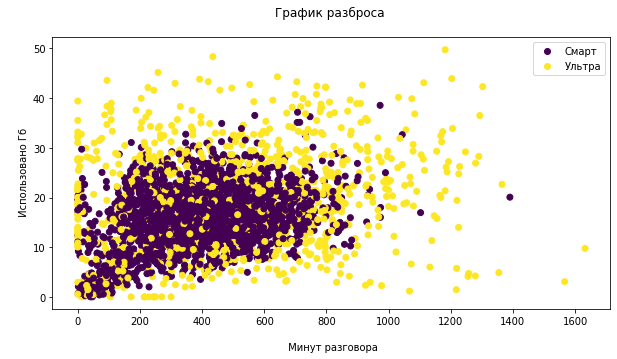

In [18]:
# Нарисуем скэттер плот 
plt.figure(figsize=(10,5))
plt.xlabel('\n Минут разговора')
plt.ylabel('\n Использовано Гб')
plt.title('График разброса \n')
class_names = ['Смарт', 'Ультра']
scatter = plt.scatter(data['minutes'], data['gb_used'], c = data['is_ultra']);
plt.legend(handles = scatter.legend_elements()[0], loc = 'upper right', labels = class_names);

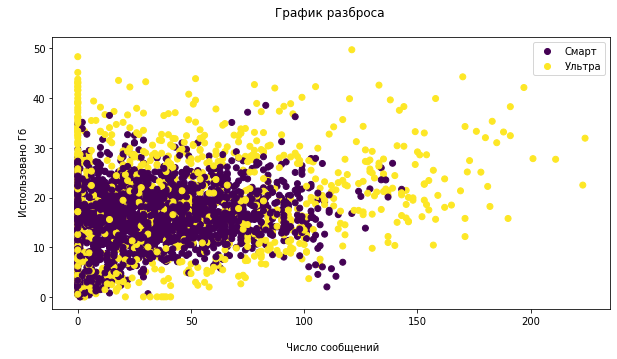

In [19]:
# Нарисуем скэттер плот 
plt.figure(figsize=(10,5))
plt.xlabel('\n Число сообщений')
plt.ylabel('\n Использовано Гб')
plt.title('График разброса \n')
class_names = ['Смарт', 'Ультра']
scatter = plt.scatter(data['messages'], data['gb_used'], c = data['is_ultra']);
plt.legend(handles = scatter.legend_elements()[0], loc = 'upper right', labels = class_names);

У Ультра есть mass point на нуле сообщений.

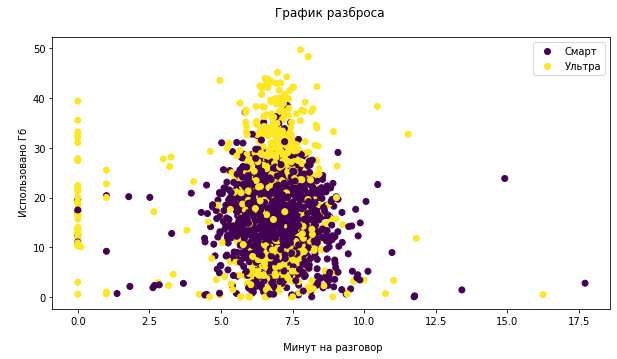

In [20]:
# Нарисуем скэттер плот 
plt.figure(figsize=(10,5))
plt.xlabel('\n Минут на разговор')
plt.ylabel('\n Использовано Гб')
plt.title('График разброса \n')
class_names = ['Смарт', 'Ультра']
scatter = plt.scatter(data['minutes_per_call'], data['gb_used'], c = data['is_ultra']);
plt.legend(handles = scatter.legend_elements()[0], loc = 'upper right', labels = class_names);

Те, кто вообще не говорили по телефону были практически всегда их тарифа Ультра. 

 У нас появилось некоторое первое представление о распределении классов и какая-то первая идея о том, как, например, дерево могло бы отсекать некоторые очевидные классы. 

### Дерево решений

#### Точность на валидационной выборке

Я посмотрю на разные деревья решений и выберу то, которое даёт наибольшую accuracy на валидационной выборке

In [59]:
# Рассмотрим разные деревья решений
best_accuracy_tree = 0
best_tree = None
depth_list=[]
accuracy_list=[]
for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state = 42, max_depth = depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(predictions_valid, target_valid)
    depth_list.append(depth)
    accuracy_list.append(accuracy)
    if accuracy>best_accuracy_tree:
        best_accuracy_tree = accuracy
        best_tree = model
display(best_tree)
best_accuracy_tree

DecisionTreeClassifier(max_depth=4, random_state=42)

0.7822706065318819

Из всех деревьев, наилучшей с точки зрения accuracy на валидационной выборке оказалось дерево глубиной 4 и accuracy на валидационной выборке получилась 0.78

Посмотрю, как вела себя метрика при разных значениях глубины.

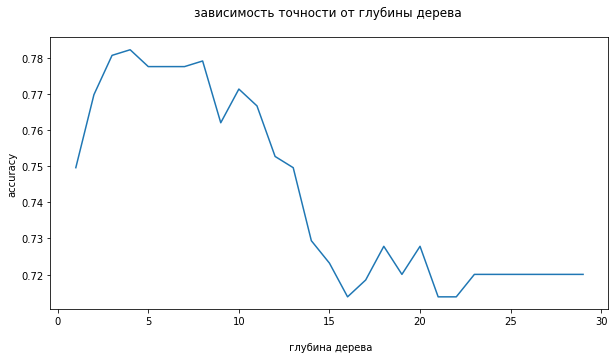

In [60]:
# график
plt.figure(figsize = (10,5))
plt.title('зависимость точности от глубины дерева \n')
plt.xlabel('\n глубина дерева')
plt.ylabel('accuracy')
plt.plot(depth_list, accuracy_list);

Видно, что начиная с глубины 4 точность на валидационной выборке начинает резко падать.

#### Grid search на обучающей выборке

Попробуем теперь провести поиск по подмножеству гиперпараметров, используя grid search.

In [22]:
# Ищем оптимальные параметры
param_grid = {'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(features_train, target_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9]},
             verbose=True)

In [23]:
# Посмотрим на найденное дерево
best_search_tree = grid_search.best_estimator_
best_search_tree.get_params()

{'ccp_alpha': 0.01,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [24]:
# Посчитаем accuracy
predict_valid_search = best_search_tree.predict(features_valid)
best_search_accuracy = accuracy_score(predict_valid_search, target_valid)
best_search_accuracy

0.7853810264385692

У нас получилась большая accuracy на валидационной выборке, что и у дерева, которое я нашла ранее перебором некоторых гиперпараметров.  

#### Cross-validation score

Теперь рассмотрим модель решающего дерева и будем использовать все данные (train+valid) и рассчитывать cross-validation score. Будем отбирать модели по лучшему среднему score.

In [27]:
# сделаем новый набор обучающих и тренировочных данных
features_train2, features_test2, target_train2, target_test2 = (
    train_test_split(features, target, test_size=0.2, random_state=42, stratify = target)
)
display(features_train2.shape[0])
features_test2.shape[0]

2571

643

In [28]:
# подбираем лучшее дерево
tree_cross = None
score_cross = 0
for depth in range(1, 10):
    dtc = DecisionTreeClassifier(random_state=42, max_depth = depth)
    scores = cross_val_score(dtc, features_train2, target_train2, cv=5)
    if scores.mean()>score_cross:
        tree_cross = dtc
        score_cross = scores.mean()

In [29]:
# результаты
display(tree_cross)
score_cross

DecisionTreeClassifier(max_depth=3, random_state=42)

0.7837490083487589

In [30]:
# обучаем дерево
tree_cross.fit(features_train2, target_train2)

DecisionTreeClassifier(max_depth=3, random_state=42)

Используя метод cross validation, у нас получилось отпимальное дерево глубиной 3, но при этом средняя точность получилась чуть ниже, чем дерево, которое мы отбирали с помощью grid search. 

### Случайный лес

#### Точность на валидационной выборке

In [34]:
# Рассмотрим теперь семейство моделей случайного леса
best_accuracy_forest = 0
best_forest = None
for est in range(2, 20):
    for depth in range(1, 15):
        model = RandomForestClassifier(random_state=42, max_depth = depth, n_estimators = est)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        accuracy = accuracy_score(predictions_valid, target_valid)
        if accuracy>best_accuracy_forest:
            best_accuracy_forest = accuracy
            best_forest = model
display(best_forest)
best_accuracy_forest

RandomForestClassifier(max_depth=8, n_estimators=19, random_state=42)

0.8009331259720062

Наилучшая модель случайного леса на валидационной выборке была с максимальной глубиной 8 и 19 деревьями. Данная модель также с точки зрения accuracy на валидационной выборке сработала лучше, чем дерево решений. 

#### OOB score

Модель случайного леса позвонляет считать OOB score, то есть использовать все возможные данные для обучения, не деля на валидационную выборку, и считать процент корректно предсказанных строк среди тех, что не были выбраны для обучения модели в каждой конкретной реализации случайного дерева. 

In [35]:
# выбираем лучший случайный лес на основе oob score
best_oob_score = 0
best_oob_forest = None
for est in range(20, 30):
    for depth in range(1, 10):
        model = RandomForestClassifier(random_state=42, max_depth = depth, n_estimators = est, oob_score=True)
        model.fit(features_train2, target_train2)
        if model.oob_score_>best_oob_score:
            best_oob_score = model.oob_score_
            best_oob_forest = model
display(best_oob_forest)
best_oob_score

RandomForestClassifier(max_depth=7, n_estimators=27, oob_score=True,
                       random_state=42)

0.8043562816024893

Мы получили ещё одну модель случайного леса, с максимальной глубиной 7 и 27 деревьями. Данная модель обучалась на большей выборке данных, чем предыдущие модели (то есть, она обучалась и на валидационной выборке, на которой предыдущие модели не обучались). При этом точность этой модели на основа oob score немного выше, чем точность модели случайного леса, которую я отбирала на валидационной выборке.

#### Grid search

Теперь используем поиск по параметрам с помощью grid search. 

In [36]:
# рассматриваемые параметры
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8, 9],
    'criterion' :['gini', 'entropy']
}

In [37]:
# поиск по параметрам
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 20, 30]})

In [38]:
# лучшая модель
best_search_forest = CV_rfc.best_estimator_
best_search_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 30,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [39]:
# считаем accuracy
predictions_valid = best_search_forest.predict(features_valid)
accuracy_search_forest = accuracy_score(predictions_valid, target_valid)
accuracy_search_forest

0.7962674961119751

Данная модель имеет чуть меньшую точность на валидационной выборке, чем та модель случайного леса, которую мы получили с помощью oob score.

#### Cross-validation score

In [40]:
# подбираем лучший лес
forest_cross = None
score_cross = 0
for est in range(20, 30):
    for depth in range(1, 10):
        rfc = RandomForestClassifier(random_state=42, max_depth=depth, n_estimators=est)
        scores = cross_val_score(rfc, features_train2, target_train2, cv=5)
        if scores.mean()>score_cross:
            forest_cross = rfc
            score_cross = scores.mean()

In [42]:
display(forest_cross)
score_cross

RandomForestClassifier(max_depth=9, n_estimators=29, random_state=42)

0.8070892675002833

In [63]:
# обучим модель
forest_cross.fit(features_train2, target_train2)

RandomForestClassifier(max_depth=9, n_estimators=29, random_state=42)

Точность на основе cross-validation получилась выше, чем точность в предыдущих моделях случайного леса. На данный момент дерево из 29 деревьев с максимальное глубиной 9 показывает наибольшую точность.

### Логистическая регрессия

#### Точность на валидационной выборке

Теперь посмотрим, как будет работать классификация с помощью логистической регрессии.

In [43]:
model_logit = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000)
model_logit.fit(features_train, target_train)
predictions_valid = model_logit.predict(features_valid)
accuracy_logit = accuracy_score(predictions_valid, target_valid)
accuracy_logit

0.7418351477449455

У логистической регрессии получилась точность на валидационной выборке хуже, чем у дерева решений и случайного леса. 

#### Grid search

Посмотрим, как можно оптимизировать параметры у логистической регрессии.

In [44]:
# параметры
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [45]:
# поиск по параметрам
logreg = LogisticRegression()
logreg_search = GridSearchCV(logreg, 
                   param_grid = parameters,
                   scoring='accuracy',       
                   cv=10)  

In [46]:
# обучаем модель
import warnings
warnings.filterwarnings('ignore') # отключим предупреждения, чтобы не отвлекали
logreg_search.fit(features_train,target_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [47]:
# подобранная модель
logreg_search.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

In [48]:
# проверим на валидационной выборке
predictions_valid = logreg_search.predict(features_valid)
accuracy_logreg_search = accuracy_score(predictions_valid, target_valid)
accuracy_logreg_search

0.744945567651633

На валидационной выборке данная модель показала точность немного лучше, чем наша изначвальная. В целом модели логистической регрессии у нас на валидационной выборке проигрывают моделям дерева решений и случайного леса. 

#### Cross-validation

In [49]:
# считаем точность по разбиениям
logreg = LogisticRegression(solver='lbfgs',  random_state=42, max_iter=1000)
scores = cross_val_score(logreg, features_train2, target_train2, cv=5)
display(scores)
scores.mean()

array([0.72621359, 0.75291829, 0.74124514, 0.75486381, 0.73735409])

0.7425189830380416

Всё равно точнось логистической регрессии в данной задаче уступает моделям решающего дерева и случайного леса.

В данном разделе я рассмотрела три класса моделей для задачи классификации: модель решающего дерева. модель случайного леса и модель логистической регрессии.
Наибольшую точность на валидационной выборке показала модель случайного леса глубиной 8 с 19 деревьями.
Из класса моделей решающих деревьев наиболее перспективным кажется дерево глубиной 5, которое я нашла с помощью grid search.
Для модели случайного леса я также провела подсчёт OOB score и оптимальный лес тогда состоял из 27 деревьев с максимальной глубиной 7. 
Логистическая регрессия оказалась менее точной и не преодолела порог точности в 0.75.

По результатам исследования модели, наилучшей моделью с точки зрения тестовой выборки оказалась модель случайного леса из 29 деревьев с максимальной глубиной 9.

## Проверьте модель на тестовой выборке

Наша модель - это модель случайного леса из 29 деревьев с глубиной 9. Проверим, какую точность она показывает на тестовой выборке.

In [64]:
# accuracy
predictions_test = forest_cross.predict(features_test)
accuracy_test = accuracy_score(predictions_test, target_test)
accuracy_test

0.8087091757387247

Случайный лес на тестовой выборке тоже показывает хорошую точность.

В данном разделе я протестировала отобранную моедль на тестовой выборке. Точность на тестовой выборке тоже высокая, наша модель не переобучена. 

## (бонус) Проверьте модели на адекватность

Сравним модель с какими-то другими наивными способами классификации.

### Случайная классификация

Во-первых, я сравню модель со случайной классификацией, где тарифы просто присваиваются человеку случайным образом с вероятностью 0.5

In [65]:
# случайно зададим тарифы
random_tariff = bernoulli.rvs(p=0.5, size = len(target_test))

Теперь оценим, какую точность даст такое случайное распределение тарифов

In [66]:
# accuracy
accuracy_random = accuracy_score(random_tariff, target_test)
accuracy_random

0.49300155520995337

Если бы наша модель просто случайно распределяла тарифы, то точность была бы лишь около 50%. Модели, которые мы обучали и отобрали, имеют точность намного выше.

### Dummy Classifier

Сравню теперь нашу модель с разными опциями наивной классификации

In [68]:
# Самый частый класс
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train2, target_train2)
predictions = dummy_clf.predict(features_test)
accuracy_dummy = accuracy_score(target_test, predictions)
accuracy_dummy

0.6936236391912908

Действительно, такая наивная модель всё время предстказывала, что пользователь будет из тарифа смарт, потому что их большинство, в том числе и в тренировочной выборке. Но это будет верно лишь в 70% случаев, а наша модель более точная.

Проверка на адекватность показала, что наши модели адекватные и работают лучше, чем просто случайное присвоение тарифов, и лучше, чем всем без разбора присваивать наиболее распространённый тариф.

В данном проекте я построила и сравнила модели классификации на пользователей тарифов Ультра и пользователей тарифов Смарт. 

В первой части я загрузила данные и немного их исследовала. Таблица корреляций показала, что общее колличество минут разговора и число звонков очень сильно скоррелированы друг с другом, как будто бы одна является практически функцией от другой. Но при этом, со средней длиной разговора они скоррелированы не очень сильно, поэтому я ввела новую перемненную со средней длиной разговора. Я также перевела мб в гб.

В следующей части я разбила данные на выборки: я создала первый набор данных, который я разбила на тренировочную, валидационную и тестовую выборки в пропорции 3:1:1. Я так же создала второй набор данных, которые разбила лишь на тренировочную и тествую выборки, потому что их я использовала в моделях с другим способом валидации. При разбиении на выборки я сохранила пропорции классов внутри подвыборок.

Далее я исследовала три основных класса моделей классификации: дерево решений, случайный лес и логистическую регрессию. В каждом классе моделей я 1) перебирала гиперпараметры, сравнивая полученную точность на валидационной выборке; 2)применяла gridsearch на обучающей выборке для подбора гиперпараметров; и 3) использовала кросс-валидацию. В модели случайного леса я дополнительно использовала oob score для отбора модели. 

В результате сравнения точность разных моделей на валидационной выборке, я остановила свой выбор на модели случайного леса.

Отобранная модель показали высокую точность на тестовой выборке, то есть модель не была переобучена.

Модель также прошли проверку на адекватность и показала намного лучшую точность, чем просто случайное присвоение классов либо же присвоение наиболее частого класса для всех.